In [17]:
# Project done in a linux/conda environment
# Install required dependencies from env.yml
# Uses NVIDIA GPU accelerationy

import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
# Run to download and extract the data used for the project (~1.6 GB)

import gdown
import py7zr
import os

def download_file_from_google_drive(file_id, destination):
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, destination, quiet=False)
    print(f"Downloaded: {destination}")

def extract_7z_file(archive_path, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)

    with py7zr.SevenZipFile(archive_path, mode='r') as archive:
        archive.extractall(path=extract_to)
    print(f"Extracted {archive_path} to {extract_to}")

file_id = "1EJMhh3cPRkixMXUCvKaUZpglt3KldKIX"
destination_path = "data.7z"
extracted_folder = "data"

download_file_from_google_drive(file_id, destination_path)
extract_7z_file(destination_path, extracted_folder)

Downloading...
From (original): https://drive.google.com/uc?id=1EJMhh3cPRkixMXUCvKaUZpglt3KldKIX
From (redirected): https://drive.google.com/uc?id=1EJMhh3cPRkixMXUCvKaUZpglt3KldKIX&confirm=t&uuid=fe0dc680-06ba-4c0e-ab31-5d671a14cbd8
To: /home/vishalreddy2011/projects/upfrp/data.7z
100%|██████████| 1.69G/1.69G [33:20<00:00, 846kB/s]  


Downloaded: data.7z
Extracted data.7z to data


In [18]:
import pandas as pd

data_dir = './data/data'
image_counts = {}

for produce_folder in os.listdir(data_dir):
    if produce_folder.startswith('fresh_'):
        condition = 'fresh'
        produce = produce_folder[len('fresh_'):]
    elif produce_folder.startswith('rotten_'):
        condition = 'rotten'
        produce = produce_folder[len('rotten_'):]
    else:
        continue

    produce_path = os.path.join(data_dir, produce_folder)
    num_images = len(os.listdir(produce_path))

    if produce not in image_counts:
        image_counts[produce] = {'fresh': 0, 'rotten': 0}

    image_counts[produce][condition] = num_images

for produce in image_counts:
    image_counts[produce]['total'] = image_counts[produce]['fresh'] + image_counts[produce]['rotten']

df = pd.DataFrame(image_counts).T
df.loc['total'] = df.sum()

print(df)

        fresh  rotten  total
apple    1507    1945   3452
orange   3492    2843   6335
banana   2048    2912   4960
total    7047    7700  14747


In [19]:
from imgaug import augmenters as iaa

seq = iaa.Sequential([
    iaa.Fliplr(0.1),
    iaa.Flipud(0.1),
    iaa.Sometimes(0.1,iaa.OneOf([
        iaa.MultiplyAndAddToBrightness(mul=(0.8,1.2), add=(-15,15)),
        iaa.GammaContrast((0.8,1.2), per_channel=True)
    ])),
    iaa.Sometimes(0.2, iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-30, 30),
        shear=(-8, 8)
    )),
    iaa.SomeOf((0,2),[
        iaa.AveragePooling([1,4], keep_size=True),
        iaa.JpegCompression(compression=(80,95)),
        iaa.OneOf([
            iaa.AdditiveGaussianNoise(scale=(0,0.1*255), per_channel=True),
            iaa.AdditiveGaussianNoise(scale=(0,0.1*255), per_channel=False)
        ]),
        iaa.OneOf([
            iaa.GaussianBlur(sigma=(0,3)),
            iaa.MotionBlur(k=10)
        ])
    ], random_order=True)
], random_order=True)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = 'data/data'
datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.1)
def preprocess_and_scale(img):
    img = seq(image=img.astype(np.uint8))
    return img / 255.0

datagen_train = ImageDataGenerator(
    validation_split=0.1,
    preprocessing_function=preprocess_and_scale
)


datagen_val = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.1)

train_generator = datagen_train.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='sparse',
    subset='training'
)

validation_generator = datagen_val.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)
y_true = validation_generator.classes

Found 13267 images belonging to 6 classes.
Found 1471 images belonging to 6 classes.


In [10]:
list(train_generator.class_indices.keys())

['fresh_apple',
 'fresh_banana',
 'fresh_orange',
 'rotten_apple',
 'rotten_banana',
 'rotten_orange']

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix_from_array(cm):
    labels = ['fresh_apple', 'fresh_banana', 'fresh_orange', 'rotten_apple', 'rotten_banana', 'rotten_orange']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [12]:
train_generator.reset()
validation_generator.reset()

In [ ]:
from tensorflow.keras.applications import ResNet50
resnet_model = ResNet50(weights=None, input_shape=(224, 224, 3), classes=6)
resnet_model.compile(optimizer=Adam(1e-4), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
resnet_history = resnet_model.fit(train_generator, validation_data = validation_generator, epochs=10)

Epoch 1/10


92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.87       150
           1       0.97      0.95      0.96       204
           2       0.92      1.00      0.96       349
           3       0.96      0.56      0.71       194
           4       0.96      0.98      0.97       290
           5       0.81      0.92      0.86       284

    accuracy                           0.91      1471
   macro avg       0.91      0.89      0.89      1471
weighted avg       0.91      0.91      0.90      1471


ResNet Final Training Accuracy: 0.9284691214561462
ResNet Final Validation Accuracy: 0.9061862826347351


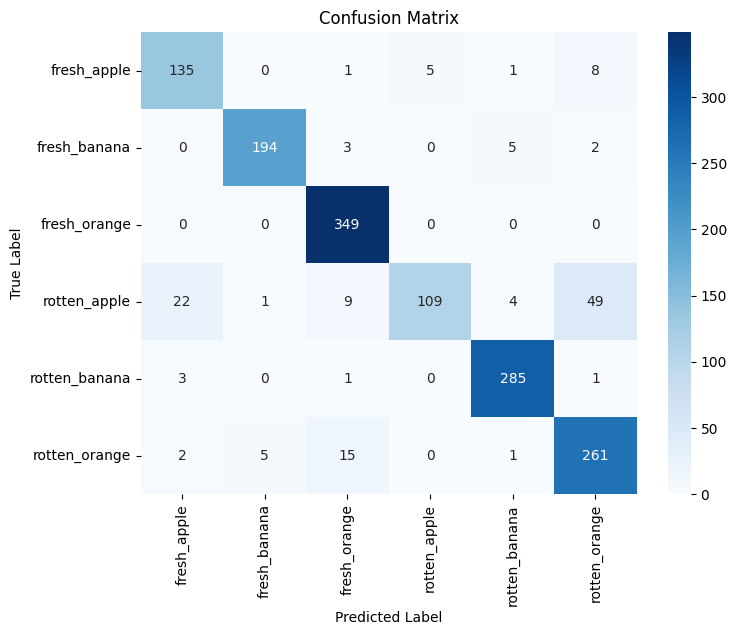

3


In [ ]:
y_pred = np.argmax(resnet_model.predict(validation_generator), axis=1)
print("\nClassification Report:\n", classification_report(y_true, y_pred))

resnet_train_accuracy = resnet_history.history['accuracy'][-1]
resnet_val_accuracy = resnet_history.history['val_accuracy'][-1]
print("\nResNet Final Training Accuracy:", resnet_train_accuracy)
print("ResNet Final Validation Accuracy:", resnet_val_accuracy)

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix_from_array(cm)
tf.keras.backend.clear_session()

In [ ]:
train_generator.reset()
validation_generator.reset()

In [ ]:
class AlexNet(models.Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.add(layers.Conv2D(96, kernel_size=(11, 11), strides=4,
                               padding='valid', activation='relu',
                               input_shape=input_shape,
                               kernel_initializer='he_normal'))
        self.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2),
                                     padding='valid'))

        self.add(layers.Conv2D(256, kernel_size=(5, 5), strides=1,
                               padding='same', activation='relu',
                               kernel_initializer='he_normal'))
        self.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2),
                                     padding='valid'))

        self.add(layers.Conv2D(384, kernel_size=(3, 3), strides=1,
                               padding='same', activation='relu',
                               kernel_initializer='he_normal'))

        self.add(layers.Conv2D(384, kernel_size=(3, 3), strides=1,
                               padding='same', activation='relu',
                               kernel_initializer='he_normal'))

        self.add(layers.Conv2D(256, kernel_size=(3, 3), strides=1,
                               padding='same', activation='relu',
                               kernel_initializer='he_normal'))

        self.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2),
                                     padding='valid'))

        self.add(layers.Flatten())
        self.add(layers.Dense(4096, activation='relu'))
        self.add(layers.Dense(4096, activation='relu'))
        self.add(layers.Dense(1000, activation='relu'))
        self.add(layers.Dense(num_classes, activation='softmax'))

        self.compile(optimizer=Adam(1e-4),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])


input_shape = (224, 224, 3)
num_classes = 6

alexnet_model = AlexNet(input_shape, num_classes)
alexnet_history = alexnet_model.fit(train_generator, validation_data = validation_generator, epochs=10)

/home/vishalreddy2011/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


2024-11-13 13:41:40.297294: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_385', 16 bytes spill stores, 16 bytes spill loads

2024-11-13 13:41:40.525179: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_392', 24 bytes spill stores, 24 bytes spill loads



829/830 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.5268 - loss: 1.2268

2024-11-13 13:43:17.263846: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_93', 20 bytes spill stores, 20 bytes spill loads

2024-11-13 13:43:18.198084: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_100', 40 bytes spill stores, 40 bytes spill loads



830/830 ━━━━━━━━━━━━━━━━━━━━ 104s 111ms/step - accuracy: 0.5271 - loss: 1.2260 - val_accuracy: 0.8049 - val_loss: 0.6404
Epoch 2/10
830/830 ━━━━━━━━━━━━━━━━━━━━ 76s 90ms/step - accuracy: 0.8343 - loss: 0.4797 - val_accuracy: 0.8253 - val_loss: 0.4902
Epoch 3/10
830/830 ━━━━━━━━━━━━━━━━━━━━ 81s 96ms/step - accuracy: 0.8908 - loss: 0.3183 - val_accuracy: 0.7825 - val_loss: 0.6942
Epoch 4/10
830/830 ━━━━━━━━━━━━━━━━━━━━ 79s 94ms/step - accuracy: 0.9116 - loss: 0.2714 - val_accuracy: 0.8253 - val_loss: 0.6522
Epoch 5/10
830/830 ━━━━━━━━━━━━━━━━━━━━ 77s 92ms/step - accuracy: 0.9260 - loss: 0.2143 - val_accuracy: 0.8885 - val_loss: 0.3206
Epoch 6/10
830/830 ━━━━━━━━━━━━━━━━━━━━ 78s 93ms/step - accuracy: 0.9368 - loss: 0.1917 - val_accuracy: 0.9123 - val_loss: 0.2801
Epoch 7/10
830/830 ━━━━━━━━━━━━━━━━━━━━ 80s 95ms/step - accuracy: 0.9443 - loss: 0.1685 - val_accuracy: 0.9232 - val_loss: 0.3056
Epoch 8/10
830/830 ━━━━━━━━━━━━━━━━━━━━ 77s 92ms/step - accuracy: 0.9504 - loss: 0.1445 - val_accur

92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.94       150
           1       0.97      0.92      0.94       204
           2       0.98      0.99      0.98       349
           3       0.94      0.84      0.89       194
           4       0.93      1.00      0.96       290
           5       0.92      0.96      0.94       284

    accuracy                           0.95      1471
   macro avg       0.95      0.94      0.94      1471
weighted avg       0.95      0.95      0.95      1471

AlexNet Final Training Accuracy: 0.9562824964523315
AlexNet Final Validation Accuracy: 0.9483344554901123


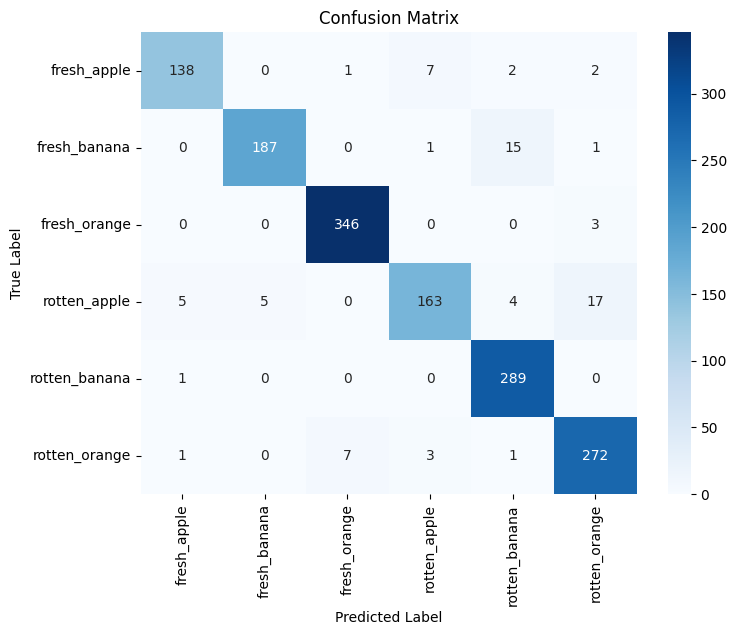

[sudo] password for vishalreddy2011: 

3


In [ ]:
y_pred = np.argmax(alexnet_model.predict(validation_generator), axis=1)
print("\nClassification Report:\n", classification_report(y_true, y_pred))

alexnet_train_accuracy = alexnet_history.history['accuracy'][-1]
alexnet_val_accuracy = alexnet_history.history['val_accuracy'][-1]
print("AlexNet Final Training Accuracy:", alexnet_train_accuracy)
print("AlexNet Final Validation Accuracy:", alexnet_val_accuracy)

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix_from_array(cm)
tf.keras.backend.clear_session()

In [ ]:
train_generator.reset()
validation_generator.reset()

In [ ]:
def create_fruitnet(num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    filters = 32
    for _ in range(4):
        filters *= 2
        model.add(layers.Conv2D(filters, (3, 3), activation="relu"))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation="relu"))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation="softmax"))
    return model

fruitnet_model = create_fruitnet(num_classes=6)
fruitnet_model.compile(optimizer=Adam(1e-4), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
fruitnet_history = fruitnet_model.fit(train_generator, validation_data = validation_generator, epochs=10)

/home/vishalreddy2011/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


2024-11-13 13:56:06.370463: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 611.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


830/830 ━━━━━━━━━━━━━━━━━━━━ 101s 108ms/step - accuracy: 0.5935 - loss: 1.5036 - val_accuracy: 0.7689 - val_loss: 0.6826
Epoch 2/10
830/830 ━━━━━━━━━━━━━━━━━━━━ 73s 88ms/step - accuracy: 0.7987 - loss: 0.5880 - val_accuracy: 0.8702 - val_loss: 0.4038
Epoch 3/10
830/830 ━━━━━━━━━━━━━━━━━━━━ 76s 90ms/step - accuracy: 0.8492 - loss: 0.4480 - val_accuracy: 0.8844 - val_loss: 0.4358
Epoch 4/10
830/830 ━━━━━━━━━━━━━━━━━━━━ 74s 89ms/step - accuracy: 0.8696 - loss: 0.3876 - val_accuracy: 0.8858 - val_loss: 0.3622
Epoch 5/10
830/830 ━━━━━━━━━━━━━━━━━━━━ 73s 87ms/step - accuracy: 0.8849 - loss: 0.3555 - val_accuracy: 0.9116 - val_loss: 0.2520
Epoch 6/10
830/830 ━━━━━━━━━━━━━━━━━━━━ 72s 86ms/step - accuracy: 0.8969 - loss: 0.3241 - val_accuracy: 0.8817 - val_loss: 0.4025
Epoch 7/10
830/830 ━━━━━━━━━━━━━━━━━━━━ 70s 83ms/step - accuracy: 0.8979 - loss: 0.3152 - val_accuracy: 0.9109 - val_loss: 0.3140
Epoch 8/10
830/830 ━━━━━━━━━━━━━━━━━━━━ 70s 84ms/step - accuracy: 0.9074 - loss: 0.2784 - val_accur

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.85      0.91       150
           1       0.98      0.94      0.96       204
           2       0.97      1.00      0.98       349
           3       0.90      0.86      0.88       194
           4       0.95      1.00      0.97       290
           5       0.93      0.96      0.94       284

    accuracy                           0.95      1471
   macro avg       0.95      0.93      0.94      1471
weighted avg       0.95      0.95      0.95      1471


FruitNet Final Training Accuracy: 0.9222130179405212
FruitNet Final Validation Accuracy: 0.9496940970420837


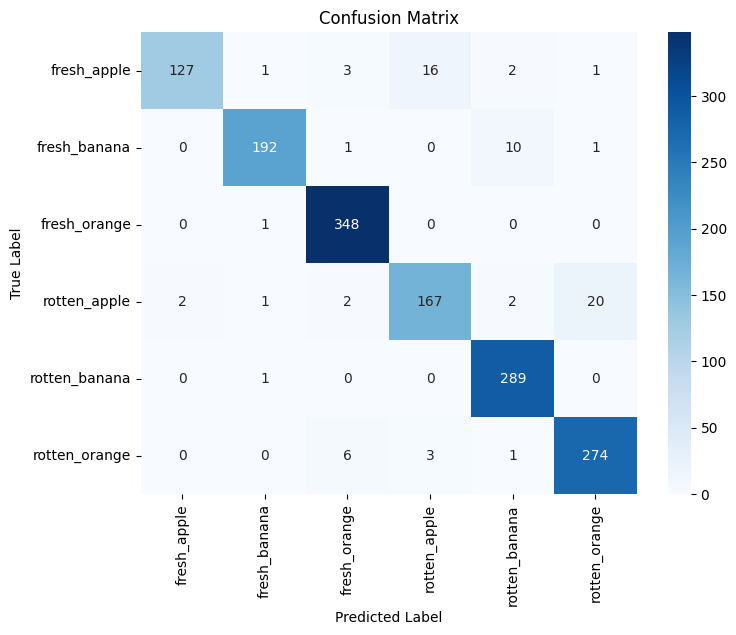

3


In [ ]:
y_pred = np.argmax(fruitnet_model.predict(validation_generator), axis=1)
print("\nClassification Report:\n", classification_report(y_true, y_pred))

fruitnet_train_accuracy = fruitnet_history.history['accuracy'][-1]
fruitnet_val_accuracy = fruitnet_history.history['val_accuracy'][-1]
print("\nFruitNet Final Training Accuracy:", fruitnet_train_accuracy)
print("FruitNet Final Validation Accuracy:", fruitnet_val_accuracy)

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix_from_array(cm)
tf.keras.backend.clear_session()